# Example: Bayesian linear regression

To show how the objects we have encountered so far can be used, we will consider the most basic example in Bayesian inference: _Bayesian linear regression_.

We consider the model

$$
    Y \sim {\cal N}(W X, \sigma^2) \text{ (likelihood)}\\
    W \sim {\cal N}(0,1) \text{ (prior) }
$$

Let's generate some data.

In [1]:
from jax import numpy as jnp
from objax import random
from matplotlib import pyplot as plt
from IPython.display import clear_output
import objax
import time
from tqdm import tqdm

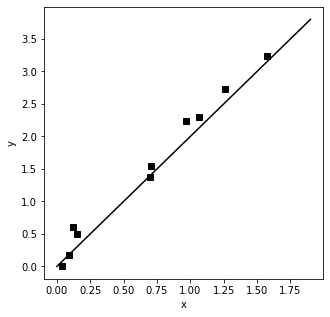

In [2]:
sigma_y = 0.2
D = 1
N = 10

x_range = jnp.array([jnp.arange(0,2,.1)]).T
x = 2 * random.uniform((N, D))
w = 2 * jnp.ones((D,))
b = 0 * jnp.zeros((1,))
y = jnp.dot(x, w) + b + sigma_y * random.normal((N,))
y = jnp.array([y]).T
y_range = jnp.dot(x_range, w) + b 

plt.figure(figsize=(5,5))
plt.plot(x, y, 'ks')
plt.plot(x_range, y_range, 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Let's now construct the _prior_ and the _likelihood_ in `GT`.

In [3]:
from gaussian_toolbox.gaussian_algebra import pdf, conditional

mu_prior = 0
sigma_prior = 1.0

# Construct prior
Sigma = jnp.array([sigma_prior ** 2.0 * jnp.eye(D)])
mu = mu_prior * jnp.ones((1, D))

# p(W)
prior = pdf.GaussianDiagPDF(Sigma=Sigma, mu=mu) # p(W)


sigma_y = 0.2

# Construct likelihood
Sigma_lk = jnp.ones((N, 1, 1)) * sigma_y ** 2
M_lk = x[:, None]

# p(Y|W)
likelihood = conditional.ConditionalGaussianPDF(M=M_lk, Sigma=Sigma_lk) # p(Y_i| X=x_i, W)

In Bayesian inference we are interest in two particular objects. One is the _posterior_ over the model parameter $W$ given the data, and the other predictive density for new points $X=x^\star$ given the posterior. We can get this objects with the affine transformations encountered before:

1. Posterior $p(W\vert X=x_i, Y) = T_{\rm cond}[p(Y\vert X=x_i, W), p(W)]$ and then condition on $Y=y_i$.
2. Predictive posterior $p(Y^\star\vert X^\star=x_j, {X=x_i, Y=y_i}) = T_{\rm marg}[p(Y^\star\vert X^\star=x_j, W), p(W\vert X=x_i, Y=y_i)]$

__Sequential inference__

In the following, we iteratively update our _posterior_ and do the _prediction_ for one data point coming in at at time.

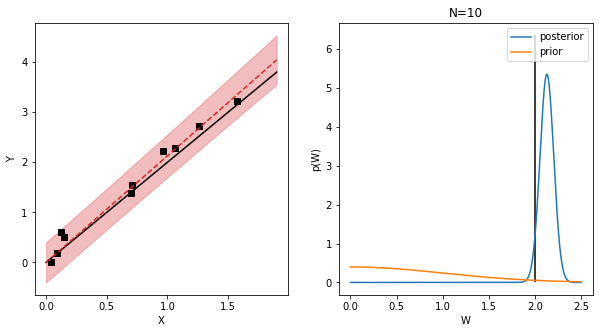

In [4]:
# Initial posterior = prior
posterior = prior

# Prediction
x_star = x_range
N_star = x_star.shape[0]
M = jnp.reshape(x_star, (N_star, 1, x_star.shape[1]))
b = jnp.zeros((N_star, 1))
Sigma = sigma_y ** 2.0 * jnp.ones((N_star, 1, 1))
predictive_conditional = conditional.ConditionalGaussianPDF(M=M, b=b, Sigma=Sigma)

predictive_posterior = predictive_conditional.affine_marginal_transformation(posterior)

# just plotting ############
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.plot(x_range, y_range, 'k')
ax1.plot(x_star, predictive_posterior.mu, 'C3--')
ax1.fill_between(x_star[:,0], predictive_posterior.mu[:,0] - 2 * jnp.sqrt(predictive_posterior.Sigma[:,0,0]),
                              predictive_posterior.mu[:,0] + 2 * jnp.sqrt(predictive_posterior.Sigma[:,0,0]),
                alpha=.3, color='C3')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

ax2 = fig.add_subplot(122)
w_range = jnp.array([jnp.arange(0,2.5,.001)]).T
ax2.plot(w_range[:,0], posterior(w_range)[0], label='posterior')
ax2.plot(w_range[:,0], prior(w_range)[0], label='prior')
ax2.vlines(w,0,jnp.amax(posterior(w_range)[0]) + 1, 'k')
ax2.set_xlabel('W')
ax2.set_ylabel('p(W)')
ax2.set_title('N=0')
plt.legend()
plt.show()
#############################

for i in range(N):
    # Updating posterior
    likelihood_i = likelihood.slice(jnp.array([i]))
    # STEP 1
    posterior_Yi = likelihood_i.affine_conditional_transformation(posterior)
    posterior = posterior_Yi(y[i:i+1])
    
    # STEP 2
    predictive_posterior = predictive_conditional.affine_marginal_transformation(posterior)
    
    # just plotting ############
    clear_output(wait=True)
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    time.sleep(1.)
    ax1.cla(), ax2.cla()
    ax2.plot(w_range[:,0], posterior(w_range)[0], label='posterior')
    ax2.plot(w_range[:,0], prior(w_range)[0], label='prior')
    ax2.vlines(w,0,jnp.amax(posterior(w_range)[0]) + 1, 'k')
    ax2.set_xlabel('W')
    ax2.set_ylabel('p(W)')
    ax2.set_title('N=%d' %(i+1))
    plt.legend()
    

    ax1.plot(x[:i+1], y[:i+1], 'ks')
    ax1.plot(x_range, y_range, 'k')
    ax1.plot(x_star, predictive_posterior.mu, 'C3--')
    ax1.fill_between(x_star[:,0], predictive_posterior.mu[:,0] - 2 * jnp.sqrt(predictive_posterior.Sigma[:,0,0]),
                                  predictive_posterior.mu[:,0] + 2 * jnp.sqrt(predictive_posterior.Sigma[:,0,0]),
                    alpha=.3, color='C3')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')

    plt.show()
    #############################

__One step inference__

Instead of doing sequential updates, of course we can also do the inference in one go. We will get the posterior in 4 steps.

1. We create the likelihood for each data point $\{p(Y\vert X=x_i, W)\}_{i=1}^N$ and set $Y=y_i$, which gets us a `ConjugateFactor`. 
2. Compute the product $\prod_{i=1}^Np(Y=y_i\vert X=x_i, W)$.
3. Multiply with prior.
4. Normalize.

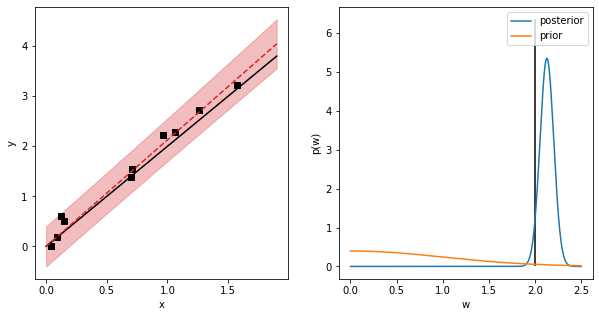

In [5]:
# Compute posterior in one go
# Step 1
likelihood_yi = likelihood.set_y(y) # p(Y=y_i| W)
# Step 2
likelihood_y = likelihood_yi.product() # \prod_i p(Y=y_i| W)
# Step 3
posterior_unnormalized = prior * likelihood_y # p(W, Y=y) = p(Y=y|W)p(W)
# Step 4
posterior = posterior_unnormalized.get_density() # p(W| Y=y)

predictive_posterior = predictive_conditional.affine_marginal_transformation(posterior)

plt.figure(figsize=(10,5))
plt.subplot(122)
plt.plot(w_range[:,0], posterior(w_range)[0], label='posterior')
plt.plot(w_range[:,0], prior(w_range)[0], label='prior')
plt.vlines(w,0,jnp.amax(posterior(w_range)[0]) + 1, 'k')
plt.xlabel('w')
plt.ylabel('p(w)')
plt.legend()
ax1 = plt.subplot(121)
ax1.plot(x[:i+1], y[:i+1], 'ks')
ax1.plot(x_range, y_range, 'k')
ax1.plot(x_star, predictive_posterior.mu, 'C3--')
ax1.fill_between(x_star[:,0], predictive_posterior.mu[:,0] - 2 * jnp.sqrt(predictive_posterior.Sigma[:,0,0]),
                              predictive_posterior.mu[:,0] + 2 * jnp.sqrt(predictive_posterior.Sigma[:,0,0]),
                alpha=.3, color='C3')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
plt.show()

__Bayesian linear regression with Neural network mean__

In the next example we will learn how neural networks, and learning thereof, can seemlessly be integrated with `GT`.

Let's consider a slightly more complex example, where we have some non-linear data.

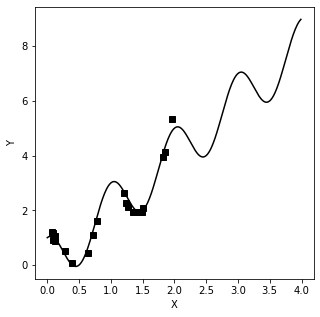

In [6]:
sigma_y = 0.2
D = 1
N = 20

f = lambda x: jnp.cos(2 * jnp.pi * x) + 2 * x

x_range = jnp.array([jnp.arange(0,4,.01)]).T
x = 2 * random.uniform((N, D))
w = 2 * jnp.ones((D,))
y = f(x[:,0]) + sigma_y * random.normal((N,))
y = jnp.array([y]).T
y_range = f(x_range)

plt.figure(figsize=(5,5))
plt.plot(x, y, 'ks')
plt.plot(x_range, y_range, 'k')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

For such a case, the `GT` provides a new conditional object `NNControlGaussianConditional`

$$
    p_\phi(Y\vert X,u) = {\cal N}(\mu_\phi(X,u), \Sigma),
$$

where $\mu_\phi(X,u)=M(u)X + b(u)$ is a neural network with parameters $\phi$. Let's construct such an object for the data we have.

In [7]:
sigma_y = 0.2
mu_prior = 0
sigma_prior = 1.0

# Construct prior
Sigma = jnp.array([sigma_prior ** 2.0 * jnp.eye(D)])
mu = mu_prior * jnp.ones((1, D))
prior = pdf.GaussianDiagPDF(Sigma=Sigma, mu=mu) # p(W)

# Construct likelihood p_u(Y_i| X=x_i, W)
Sigma_lk = jnp.ones((1, 1, 1)) * sigma_y ** 2
likelihood = conditional.NNControlGaussianConditional(Sigma=Sigma_lk, Dx=1, Du=D, 
                                                          hidden_units=[16],
                                                          non_linearity=objax.functional.tanh)

The only difference to the previous linear example is, that before using the `NNControlGaussianConditional` we need to set the control variables, which then returns a `ConditionalGaussianPDF` again.

However, we also need to learn the hyperparameters $\phi$. This can be done by minimizing the negative log marginal likelihood defined as

$$
    -\ell(\phi) = -\log \int p_\phi(Y=y\vert W, u=x)p(W){\rm d}W.
$$

As we see below, this can be computed in just a few lines in `GT`.

In [8]:
def get_neg_log_marginal_llk(X,y):
    # p(Y|W,U=x)
    likelihood_control = likelihood.set_control_variable(x)
    # p(Y=y|W,U=x)
    likelihood_product = likelihood_control.set_y(y).product()
    # p(Y=y,W|U=x) = p(Y=y|W,U=x)p(W)
    posterior_unnormalized = prior * likelihood_product
    # - log p(Y=y|U=x) = - log \int p(Y=y,W|U=x) dW
    log_marg_likelihood = posterior_unnormalized.log_integral()
    return -log_marg_likelihood.squeeze()

Since `GT` is based upon `jax` and `objax` optimization of $\phi$ is quite straightforward. 

100%|██████████| 20000/20000 [00:14<00:00, 1374.32it/s]


Text(0, 0.5, 'Neg. marginal likelihood')

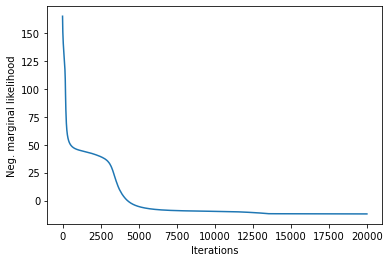

In [9]:
# OPTIMIZING WITH (OB)JAX
opt = objax.optimizer.Adam(likelihood.vars())

gv = objax.GradValues(get_neg_log_marginal_llk, likelihood.vars())
lr = 1e-3

def train_op(x, y):
    g, v = gv(x, y)  # returns gradients, loss
    opt(lr, g)
    return v

# This line is optional: it is compiling the code to make it faster.
train_op = objax.Jit(train_op, gv.vars() + opt.vars())

loss = []
for i in tqdm(range(20000)):
    loss.append(train_op(x,y))
plt.plot(loss)
plt.xlabel('Iterations')
plt.ylabel('Neg. marginal likelihood')

Now with the optimal $\phi$ we just do inference as before, with the only difference, that we need to set the hyperparameters.

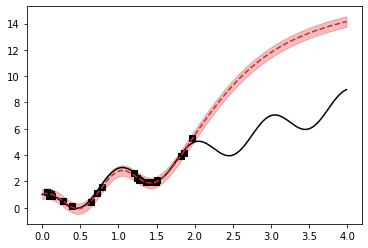

In [10]:
# GET POSTERIOR
# p(Y|W,U=x)
likelihood_control = likelihood.set_control_variable(x)
# p(Y=y|W,U=x)
likelihood_product = likelihood_control.set_y(y).product()
# p(Y=y,W|U=x) = p(Y=y|W,U=x)p(W)
posterior_unnormalized = prior * likelihood_product
# p(W|Y=y, U=x) = p(Y=y,W|U=x)/int p(Y=y,W|U=x) dW
posterio = posterior_unnormalized.get_density()

# MAKE PREDICTIONS
# p(Y*|W,U*=x*)
predictive_conditional = likelihood.set_control_variable(x_range)
# p(Y*|U*=x*, Y=y, U=x) = \int p(Y*|W,U=x*)p(W|Y=y, U=x) dW
predictive_posterior = predictive_conditional.affine_marginal_transformation(posterior)

# PLOTTING
plt.plot(x, y, 'ks')
plt.plot(x_range, y_range, 'k')
plt.plot(x_range, predictive_posterior.mu, 'C3--')
plt.fill_between(x_range[:,0], predictive_posterior.mu[:,0] - 2 * jnp.sqrt(predictive_posterior.Sigma[:,0,0]),
                              predictive_posterior.mu[:,0] + 2 * jnp.sqrt(predictive_posterior.Sigma[:,0,0]),
                alpha=.3, color='C3')
plt.show()

Of course, this is just a simple example. One more complex example is to paramterize also the covariance $\Sigma$ via control variables. You want to try it yourself? ;)